In [1]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

# Data on aviation accidents in 1976-1985

In [77]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Passenger deaths']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


# 1. The rate is constant for all years and not depending on anything.

## Prior model
First we need to create simple prior model. We will try to predict annual number of passenger deaths with poisson distribution.

$$y_i\sim\mathrm{Poisson}(\lambda)$$

We assume that the annual chance of 20 000 deaths is very small, therefore we want our distribution with a probability less than 1% to accept 20 000 deaths. 

So we need the right $\lambda$ parameter that meets this condition. Of course $\lambda$ must be greater than zero but also can't be too high. We need to find the $\lambda$ parameter of the poisson distribution for which the chance of 20 000 or more successes is equal to 1%. We will calculate it from this equation:

$$\lambda+3\sqrt{\lambda}\approx20000$$

We use here the fact that the poisson distribution (with $\lambda$ parameter) can be approximated by the normal distribution where the average of the normal distribution is equal to $\lambda$ while the slope is equal to $\sqrt{\lambda}$. However, it is known about the normal distribution that its mean plus three deviations constitute 99% of the probability mass.

In [81]:
root_of_lam=np.polynomial.polynomial.polyroots([-20000.,3.,1.])
lambda_1=np.round(root_of_lam[root_of_lam>0]**2)
print(lambda_1)

[19580.]


So $\lambda$ = 19580. This is the maximum value of the parameter for which the probability mass of the Poisson distribution above 20 000 will not exceed 1%. So we need to keep $\lambda \in (0,19580)$.

Because the lambda parameter value will be obtained from the half-normal distribution, we must provide such a sigma parameter of the half-normal distribution that the chance of obtaining values greater than 19580 is less than 1%.

In [82]:
with open('prior_model1.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 252
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}


In [171]:
model =stan_utility.compile_model('prior_model1.stan')

Using cached StanModel


In [85]:
data=dict(y_guess=np.array([np.log(10000)]),theta=np.array(lambda_1))
tuned2 = model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned2.extract()['sigma'][0])
print(sigma)

7601.0


So $\delta$ = 7601. Now we can see how half-normal distribution looks like with that parameter:

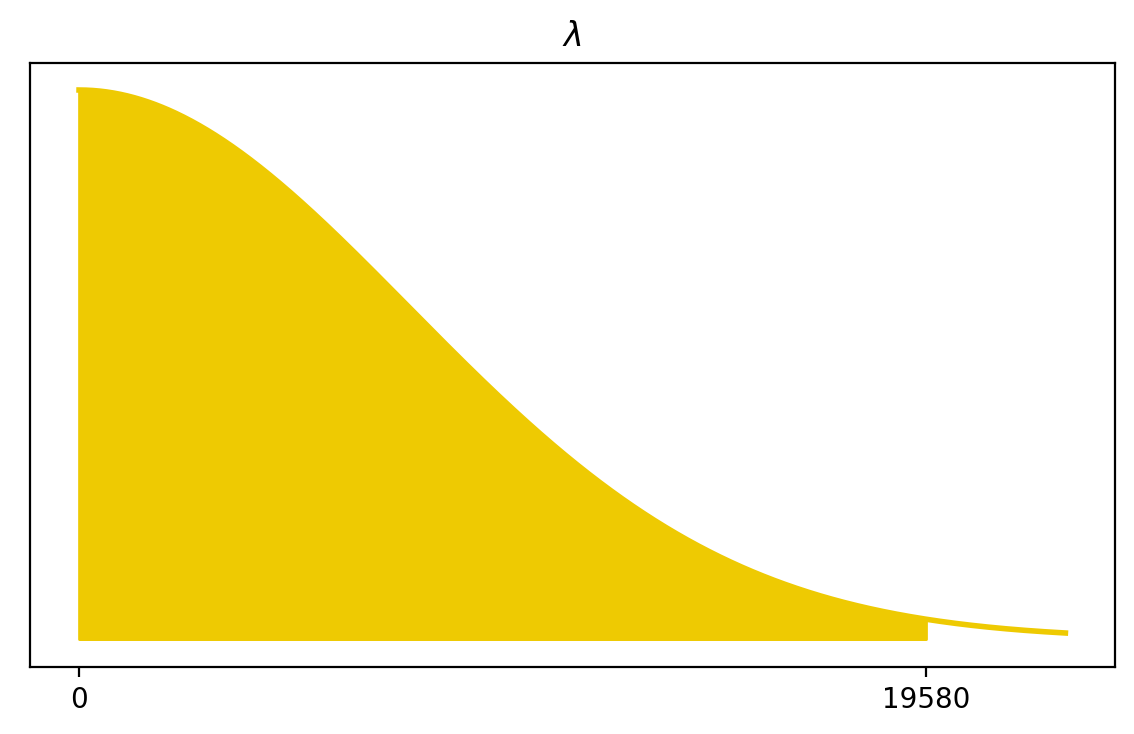

In [86]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lambda_1[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lambda_1[0]])
ax2.set_title(r'$\lambda$')
plt.show()

## Prior predictive check

Based on the calculated parameters, we can try the appropriate half-normal distribution and poisson distribution.

In [87]:
with open('prior_predictive_1.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
}


generated quantities {
  real lambda=fabs(normal_rng(0,7601));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [253]:
model_pp =stan_utility.compile_model('prior_predictive_1.stan')

Using cached StanModel


In [89]:
R=1000
sim_uf=model_pp.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

In [96]:
dta_cnt

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

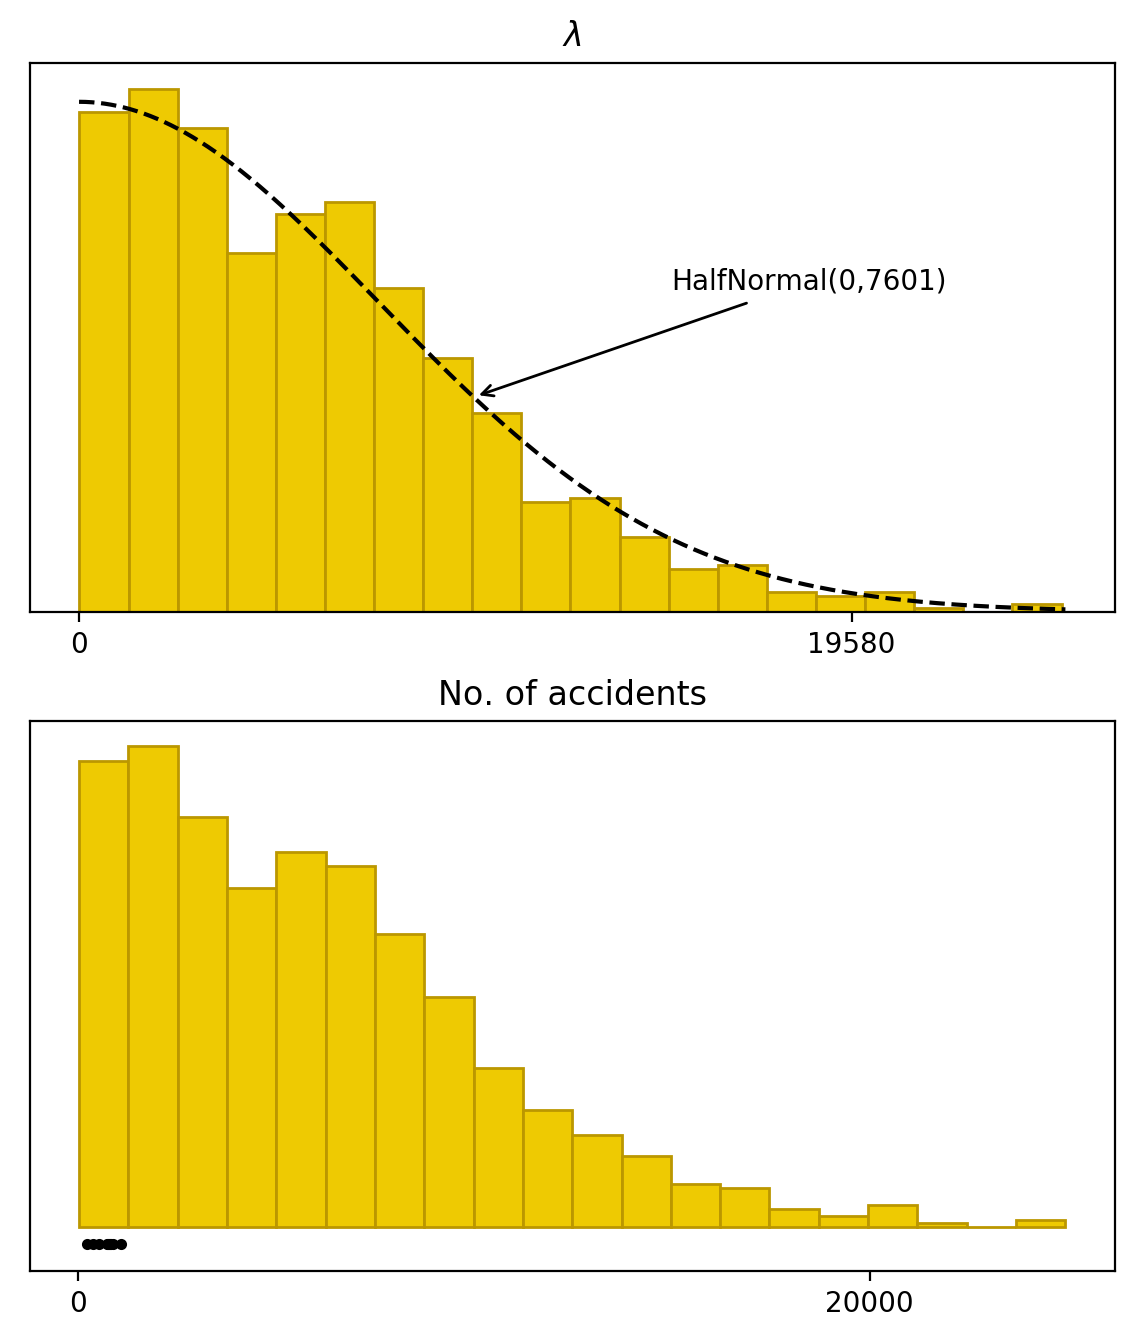

In [103]:
params=sim_uf.extract()
lambda1=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lambda1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,25000,2000)
ax1.set_xticks([0,lambda_1[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(10000,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(10000,arr_y_loc),xytext=(15000,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.000004*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,20000])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

## Posterior predictive
Now we can try to create model to predict number of deaths in 1986

In [108]:
with open('posterior_predictive1.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,7601);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [110]:
model_post =stan_utility.compile_model('posterior_predictive1.stan')

Using cached StanModel


In [113]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'])
fit = model_post.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [114]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.65
89% confidence interval: [ 678.87 705.46 ]


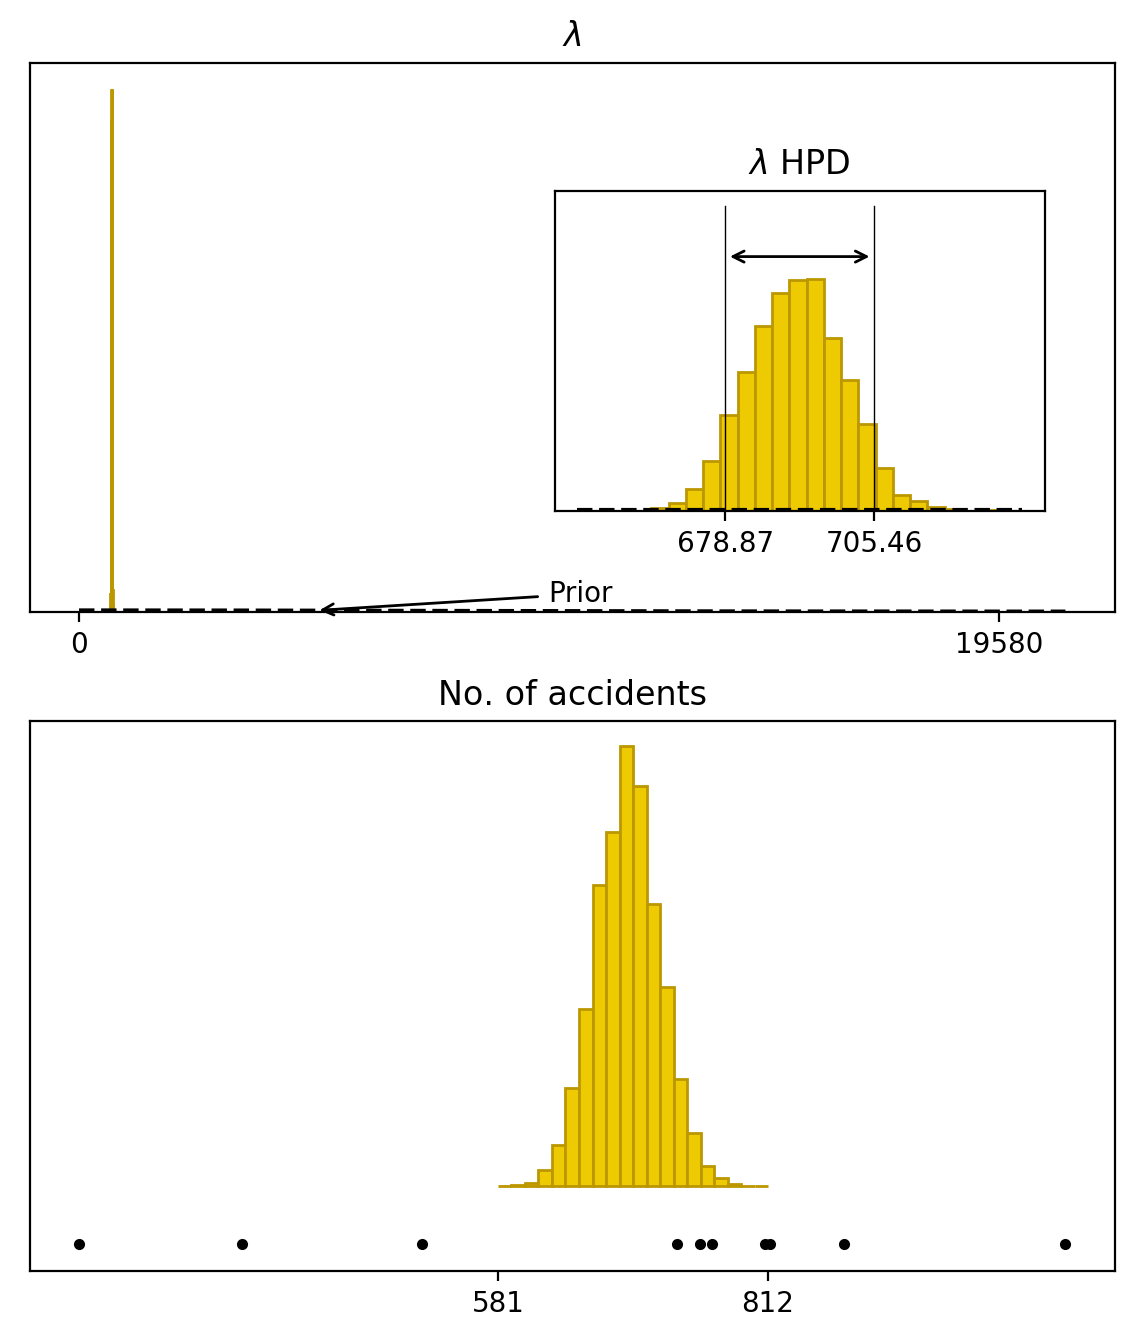

In [151]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,21000,1000)
#ax1.plot(x,2*stats.t.pdf(x,5,0,10),color='black',linestyle='--')

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(5000,0,sigma)
ax1.annotate('Prior',xy=(5000,arr_y_loc),xytext=(10000,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lambda_1[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width, cinf_lam[1]+hpd_width, 200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.05), xytext=(cinf_lam[1]+.2,0.05), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.06],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.06],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')

ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([np.min(y_sim),np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

### Using model for prediction

In 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. Lets check how our can perform such prediction.

In order to predict value in 1986 we just need to use the prior predictive distribution of y_sim.

In [168]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 692.0
Confidence interval = [ 648.0 735.0 ]


# 2. The intensity is constant, but rate is a product of intensity and miles flown.

## Prior model

Now we can try to approximate the number of deaths with a more accurate model taking into account the number of miles traveled. Now poisson distribution looks like:

$$y_i\sim\mathrm{Poisson}(\theta n)$$

With $n$ being a number miles flown (in 100 mil)

We still assume that 20 000 deaths during the year are impossible. Our previous argument, can be still valid, however in order to compute the bound we will use $\lambda=\theta\cdot\bar{n}$, with $\bar{n}$ being mean of miles flown. This gives us condition


$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx20000$$

Then we do the same as in the first section.

In [169]:
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-20000/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))



theta upper bound 3.426


In [173]:
data=dict(y_guess=np.array([np.log(1)]),theta=np.array(theta_ub))
tuned2 = model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 1.330


In [178]:
theta_ub

array([3.42562932])

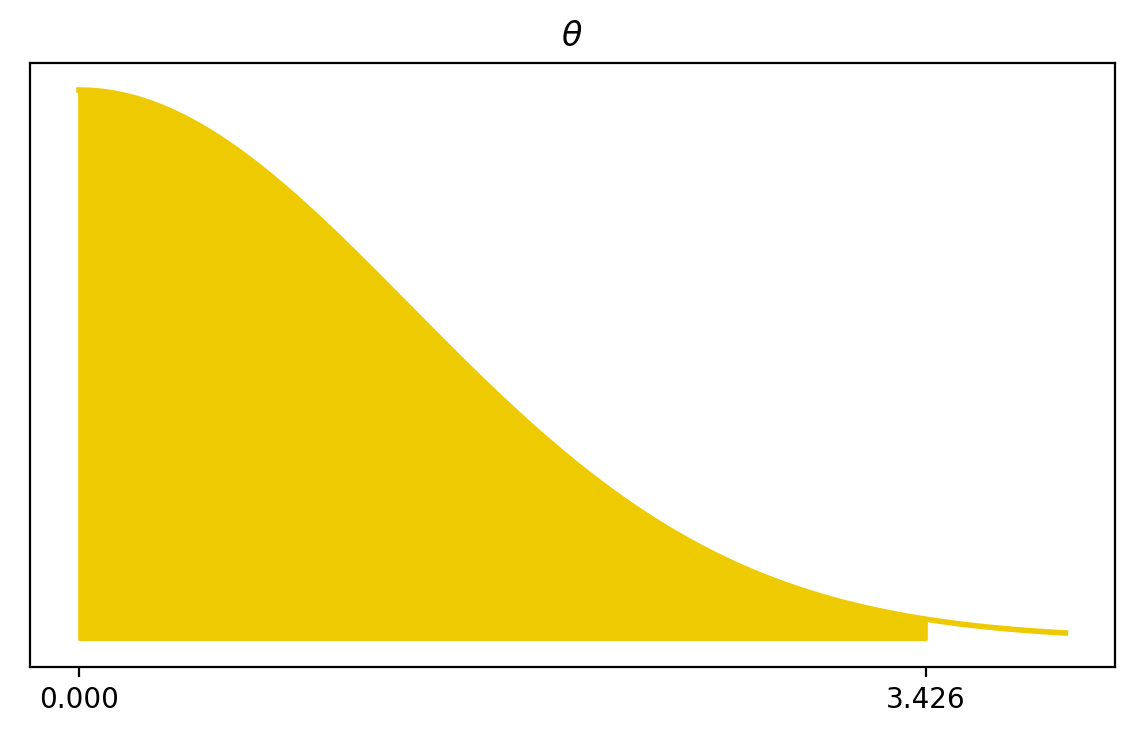

In [180]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
#ax2.set_xticklabels([0,1.330])
ax2.set_title(r'$\theta$')
plt.show()

## Prior predictive check

Based on the calculated parameters, we can try the appropriate half-normal distribution and poisson distribution.

In [183]:
with open('prior_predictive_2.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
}


generated quantities {
  real theta=fabs(normal_rng(0,1.33));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [254]:
model_prior=stan_utility.compile_model('prior_predictive_2.stan')

Using cached StanModel


In [185]:
R=1000
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

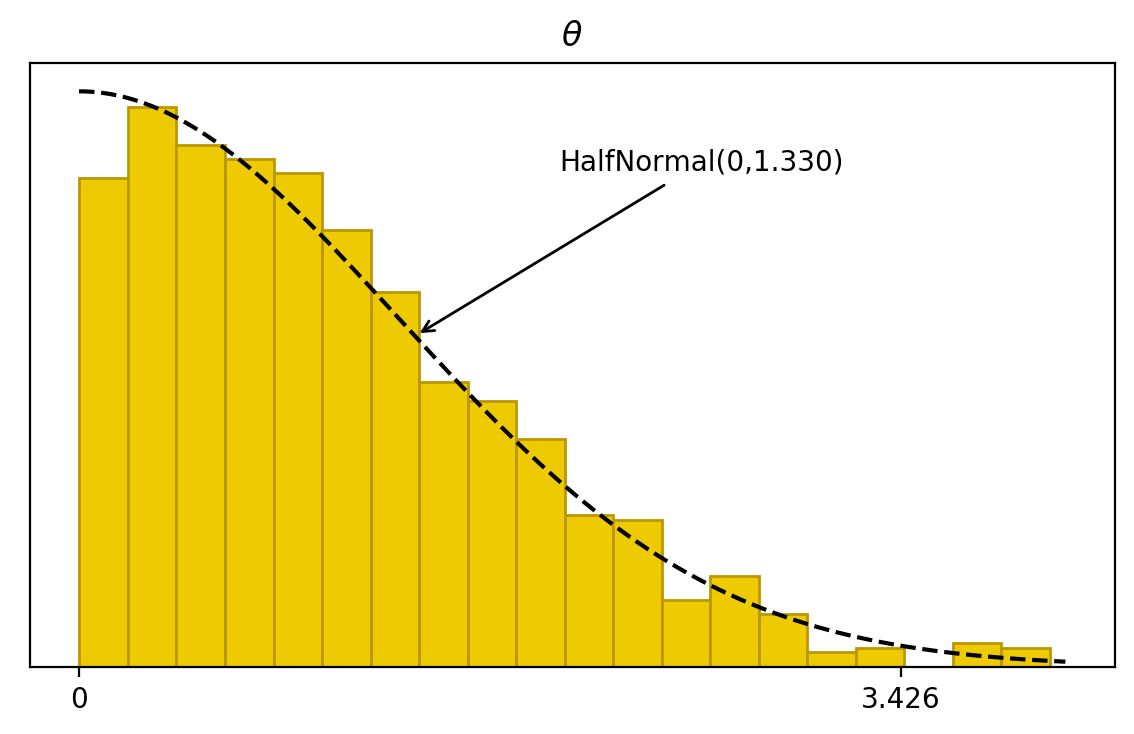

In [188]:
params=sim_uf.extract()
theta=params['theta']
#y_sim=params['y_sim']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(1.4,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(1.4,arr_y_loc),xytext=(2,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

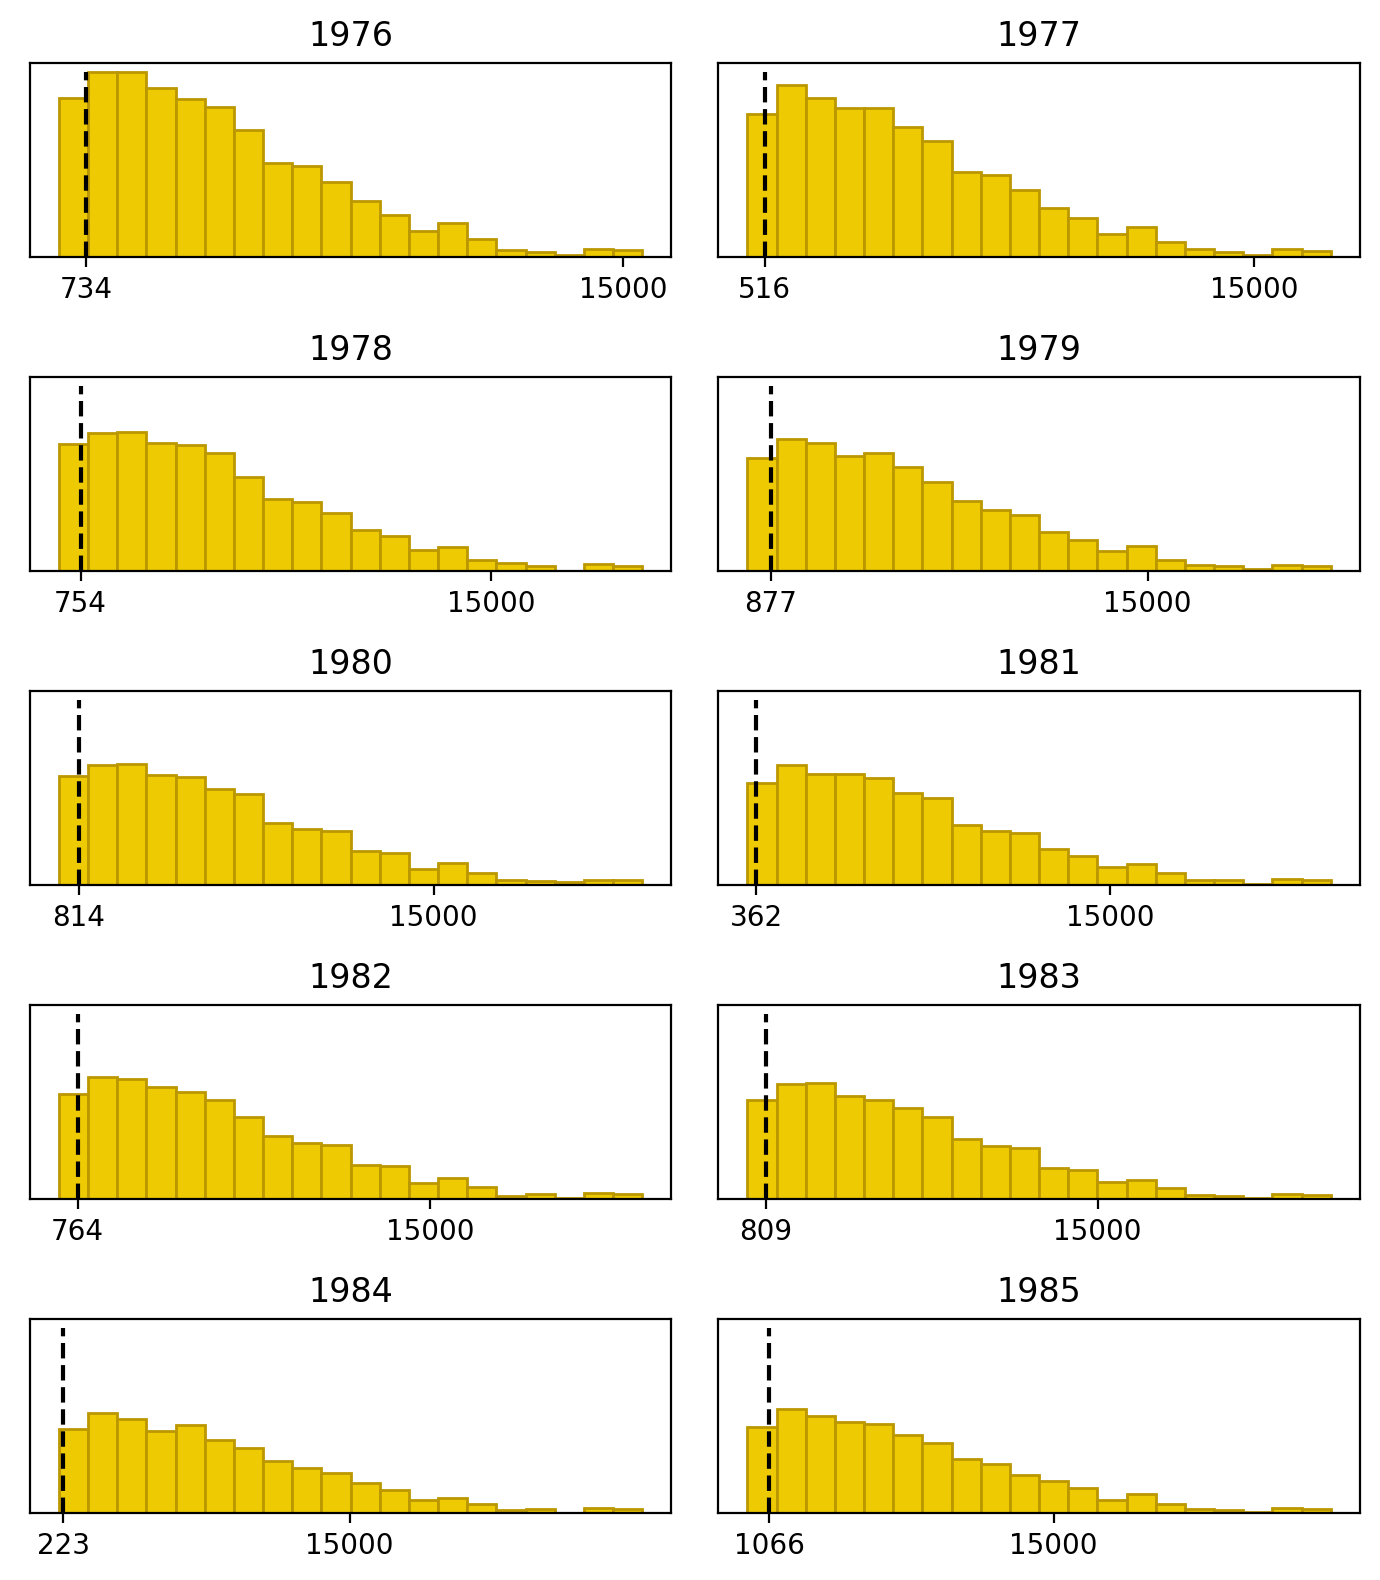

In [204]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.00015],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([tv,15000])
#     ax.set_xticklabels(['',tv,365])
#     ax.set_ylim([0,0.00015])

fig.tight_layout()

plt.show()

## Posterior predictive
Now we can try to create model to predict number of deaths in 1986

In [208]:
with open('posterior_predictive2.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,1.33);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}


In [214]:
model_miles=stan_utility.compile_model('posterior_predictive2.stan')

Using cached StanModel


In [219]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']


In [220]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [221]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1210
89% confidence interval: [ 0.1188 0.1235 ]


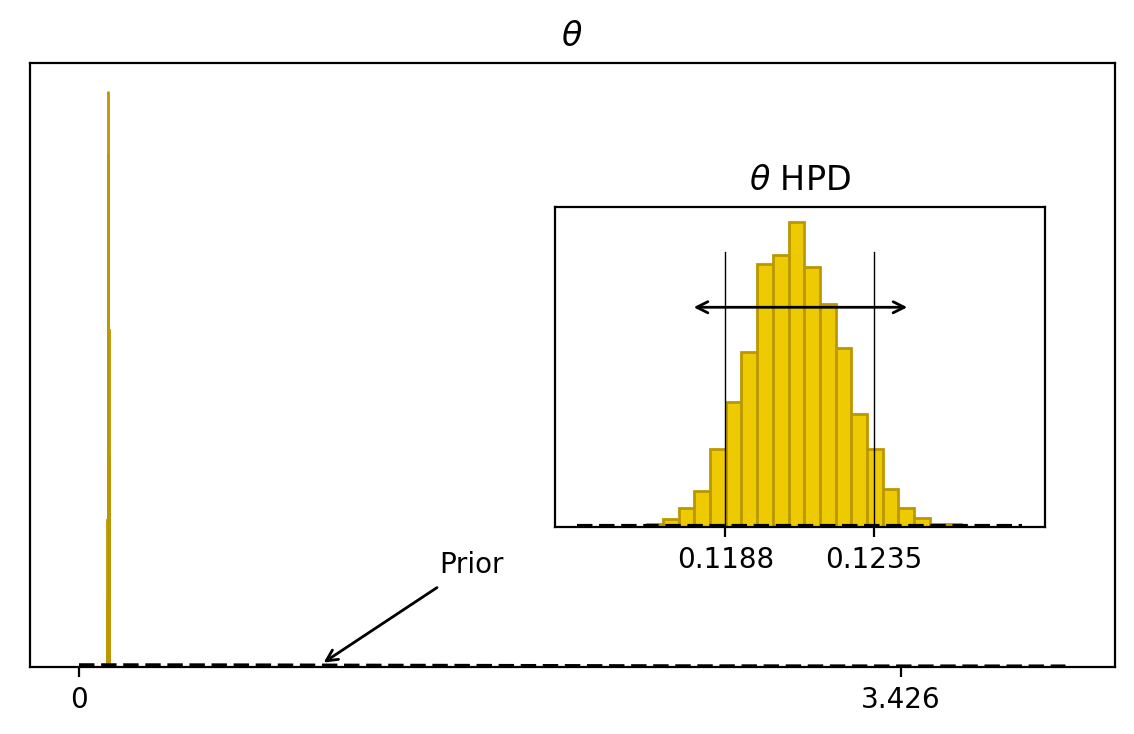

In [257]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(1,0,sigma)
ax1.annotate('Prior',xy=(1,arr_y_loc),xytext=(1.5,100*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],200), xytext=(1.01*cinf_theta[1],200), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,250],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,250],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

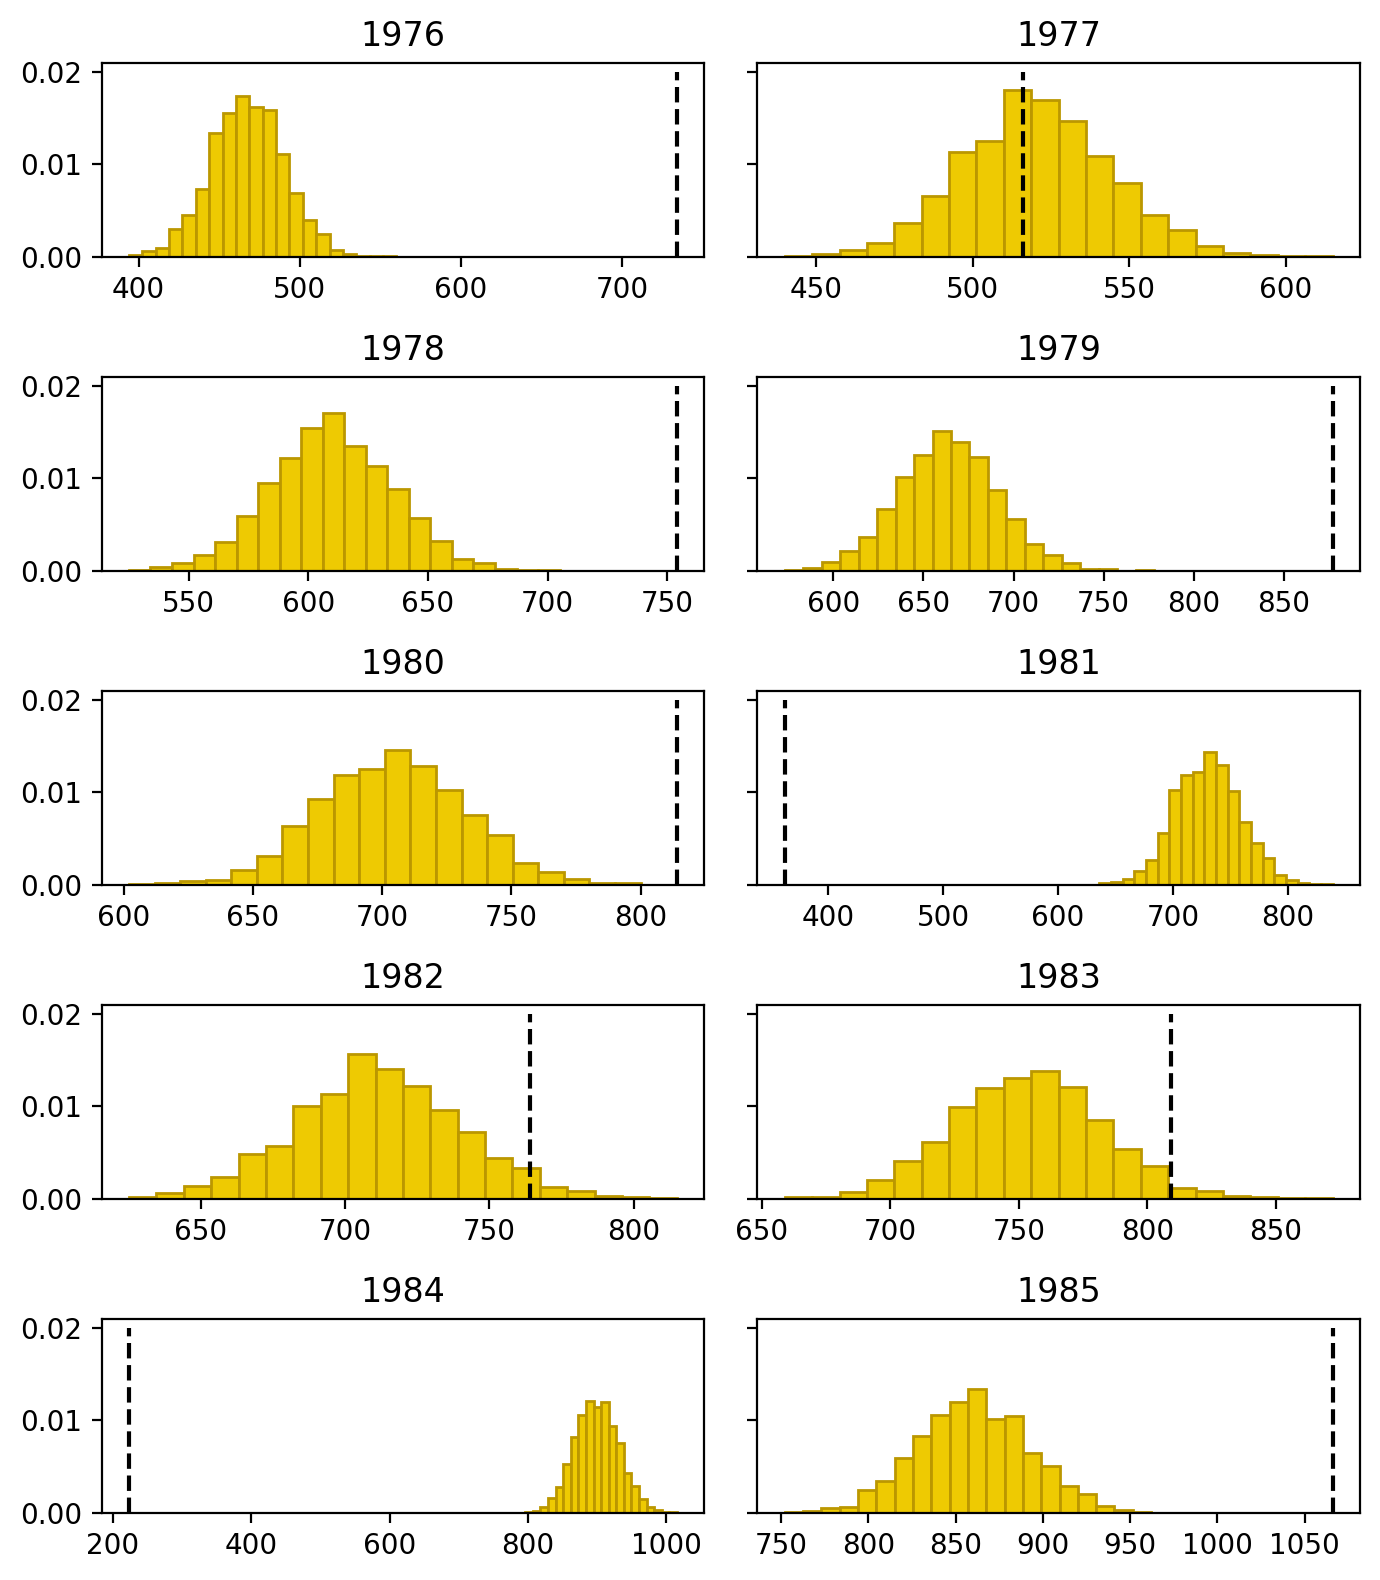

In [232]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
#     #ax.set_yticks([])
#     ax.set_xticks([0,tv,50])
#     ax.set_xticklabels([0,tv,50])
#     ax.set_ylim([0,0.15])

fig.tight_layout()

plt.show()

### Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block
As stated before in 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. 

In [234]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [238]:
with open('airline_FA_miles_1986.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,1.33);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}


In [239]:
model1986=stan_utility.compile_model('airline_FA_miles_1986.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d8a1c4f07f05669a556238cf6f551c2e NOW.


In [240]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)

y_1986=fit1986.extract()['y_1986']

In [241]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')



Median of predicted accidents = 1102.0
Confidence interval = [ 1047.0 1160.0 ]


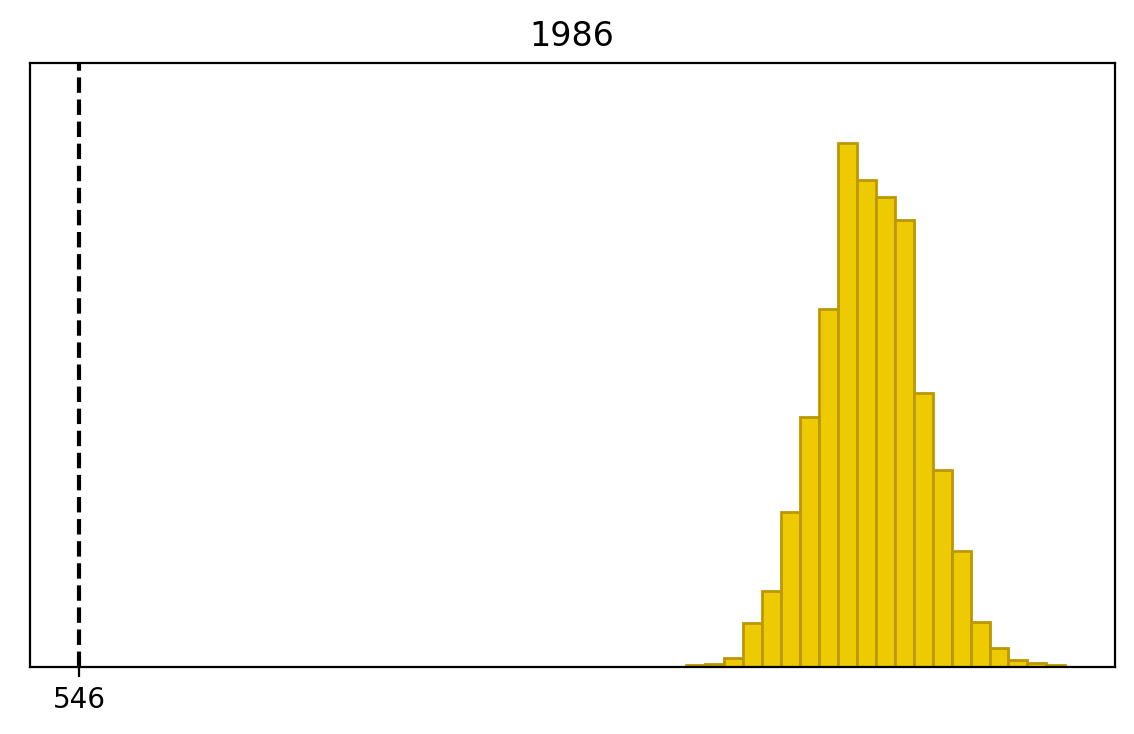

In [252]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1986')
tv = 546
ax.plot([tv,tv],[0,0.013],linestyle='--',color='black')
ax.set_yticks([])
ax.set_xticks([tv])
#ax.set_xticklabels(['0',tv,50])
ax.set_ylim([0,0.013])


plt.show()

Like we can se our prediction isn't best.